# Розробока нейронної мережі з нуля

Цей проєкт створено для поглибленного ознайомлення із алгоритмом роботи нейронних мереж. Для розробки використовуються суто структури даних Python та Numpy (бібліотека з функціями для лінійної алгебри).

In [132]:
import random
import numpy as np

## Функція активації

Функція активації використовується для використання __нелінійності__ при побудові функції класифікації (або регресії).

Найбільш поширеними функціями активації є:
- Sigmoid
- Tanh
- RelU
- LeakyRelU

Для даної нейронної мережі буде використана функція RelU:

RelU = max(0, x)

### RelU

In [133]:
def rel_u(x):
    return max(0, x)

In [134]:
rel_u(-1)

0

In [135]:
rel_u(1)

1

In [136]:
rel_u(100)

100

In [137]:
def rel_u_derivative(x):
    return 0 if x <= 0 else 1

In [138]:
rel_u_derivative(0)

0

In [139]:
rel_u_derivative(1)

1

In [140]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

### Sigmoid

In [141]:
sigmoid(10000)

1.0

In [142]:
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

In [143]:
sigmoid_derivative(10000)

0.0

In [144]:
sigmoid_derivative(0.5)

0.2350037122015945

## Нейронна мережа

In [145]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
    
    def activation(self, x):
        return sigmoid(x)
    
    def activation_derivative(self, x):
        return sigmoid_derivative(x)
    
    def forward(self):
        for layer in self.layers:
            layer.forward()
            
    def backward(self):
        for layer in self.layers:
            layer.backward()
    
    learning_rate = 0.7

# TODO akicha: непотрібна ініціалізація обʼєкту
# n = NeuralNetwork()

## Нейрон

Виступає атомарним будівельник блоком нейронної мережі

In [146]:
class Neuron:
    def __init__(self, inputs, weights, bias):
        self.inputs = inputs
        self.weights = weights
        self.bias = bias
        self.value = None
        
    def output(self):
        result = 0
        for input, weight in zip(self.inputs, self.weights):
            result += input * weight
        result += self.bias
        return result
    
    def set_inputs(self, inputs):
        self.inputs = inputs
        
    def forward(self):
        result = n.activation(self.output())
        self.value = result
        return result
    
    # TODO akicha: move the loss function to the NeuralNetwork class
    def loss(self, y, y_hat):
        return 1 / len(self.inputs) * (y - y_hat)**2
    
    def backward(self, y, y_hat):
        # L = функція визначення помилки
        # d = вираз y - y_hat
        dLdd = 2 * (y - y_hat)
        # y = rel_u(z)
        dddy = -1
        # z = sum (wx + b)
        dydz = n.activation_derivative(self.output())
        dzdw1 = self.inputs[0]
        dzdw2 = self.inputs[1]
        dzdb = 1
        # Диференціювання складної функції
        dLdw1 = dLdd * dddy * dydz * dzdw1
        dLdw2 = dLdd * dddy * dydz * dzdw2
        dLdb = dLdd * dddy * dydz * dzdb
        
        # Виконання задньої пропагації
        
        # w1
        self.weights[0] -= n.learning_rate * dLdw1
        
        # w2
        self.weights[1] -= n.learning_rate * dLdw2
        
        # b
        self.bias -= n.learning_rate * dLdb

In [147]:
class InputNeuron:
    def __init__(self, v):
        self.value = v
    
    # noop
    def forward():
        pass
    
    # noop
    def backward():
        pass

In [162]:
class Layer:
    def __init__(self, prevLayer, numNeurons):
        self.neurons = []
        self.prevLayer = prevLayer;
        inputs = prevLayer.values();
        for neuron in range(numNeurons):
            # при ініціалізації ми не знаємо правильних значень ваги тому ініціалізуємо випадково
            # пізніше, нейронна мережа сама знайде правильні значення
            weights = np.random.randn((len(inputs)))
            # при ініціалізації ми не знаємо правильного значення байесу
            # пізніше, нейронна мережа сама знайде правильне значення
            bias = np.random.randn()
            self.neurons.append(Neuron(inputs, weights, bias))
        
    def forward(self):
        inputs = self.prevLayer.values();
        
        for neuron in self.neurons:
            neuron.set_inputs(inputs)
            neuron.forward()
    
    def backward(self):
        for neuron in self.neurons:
            neuron.backward()
            
    # TODO akicha: використання методу через композицію обʼєктів
    def values(self):
        return list(map(lambda n: n.value, self.neurons))

In [149]:
class InputLayer:
    def __init__(self, inputs):
        self.neurons = []
        for i in range(len(inputs)):
            self.neurons.append(InputNeuron(i))
    
    # noop
    def forward():
        pass
    
    # noop
    def backward():
        pass
            
    def values(self):
        return list(map(lambda n: n.value, self.neurons))

## Пісочниця для тестування проміжкового резульату роботи

In [163]:
# використовується замикання щоб запобігти забруднення глобальної області видимості
def sandbox_():
    inputLayer = InputLayer([1, 2])
    print(inputLayer.values())
    hiddenLayer = Layer(inputLayer, 2)
    hiddenLayer.forward()
    print(hiddenLayer.values())
    # outputLayer = Layer(hiddenLayer, 1)
    # nn = NeuralNetwork([inputLayer, hiddenLayer, outputLayer])
    
sandbox_()

[0, 1]
[0.39233509319462945, 0.6740541994365452]


## Набір даних

In [151]:
# [length, width, class]
entities_class_1 = [
    [3, 1, 1],
    [2, 2, 1]
]

entities_class_2 = [
    [1, 3, 0],
    [1.5, 2.5, 1]
]

entities = entities_class_1 + entities_class_2

entity_secret = [1.75, 2.25]

## Візуалізація набору даних

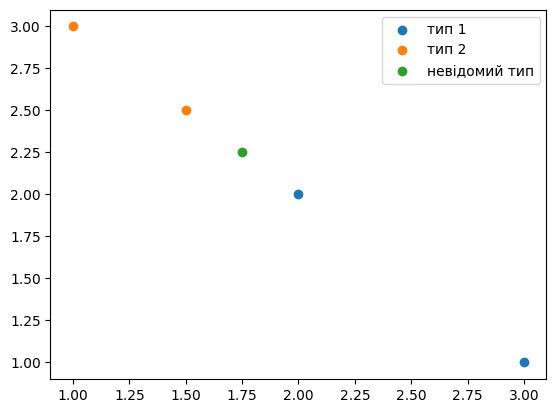

In [152]:
import matplotlib.pyplot as plt

x = list(map(lambda e: e[0], entities_class_1))
y = list(map(lambda e: e[1], entities_class_1))

x2 = list(map(lambda e: e[0], entities_class_2))
y2 = list(map(lambda e: e[1], entities_class_2))

plt.scatter(x, y)
plt.scatter(x2, y2)
plt.scatter(entity_secret[0], entity_secret[1])


plt.legend(['тип 1', 'тип 2', 'невідомий тип'])

plt.show()

## Тренування моделі

### Ініціалізація

In [153]:
neuron = Neuron([], [0.2, 0.7], 0)

plot_data = []

for i in range(1, 300):
    random_entity = random.choice(entities)
    
    neuron.set_inputs([random_entity[0], random_entity[1]])

    # print(f'Random entity is of type: {random_entity[2]}')

    # print(f'Iteration number: {i}')

    output = neuron.forward()
    # print(f'Predicted type is: {output}')
    
    loss = neuron.loss(random_entity[2], output)
    if (i % 10 == 0):
        print(f'Calculated Loss: {loss}')

    
    neuron.backward(random_entity[2], output)
    
    plot_data.append([i, loss])

Calculated Loss: 0.015881179709052316
Calculated Loss: 0.00913388482699462
Calculated Loss: 0.27615849800406983
Calculated Loss: 0.2238177363883959
Calculated Loss: 0.007929141350577753
Calculated Loss: 0.00438854442866996
Calculated Loss: 0.008185504163152705
Calculated Loss: 0.0001305815209772886
Calculated Loss: 0.00010721214961241617
Calculated Loss: 0.008823326769043289
Calculated Loss: 0.0781294197062255
Calculated Loss: 7.859919148317035e-09
Calculated Loss: 3.717117414771879e-08
Calculated Loss: 0.04287082879057698
Calculated Loss: 1.1505234458275881e-08
Calculated Loss: 0.009468645027728964
Calculated Loss: 0.050476341086451985
Calculated Loss: 1.8716803554347024e-09
Calculated Loss: 0.00015689965040436597
Calculated Loss: 0.0001313172904766361
Calculated Loss: 4.255600145429701e-05
Calculated Loss: 3.930245381142488e-10
Calculated Loss: 6.686144608011402e-11
Calculated Loss: 1.1890582777654344e-10
Calculated Loss: 6.059717276303978e-05
Calculated Loss: 1.596810763185855e-05
C

### Візуалізація прогресу тренування

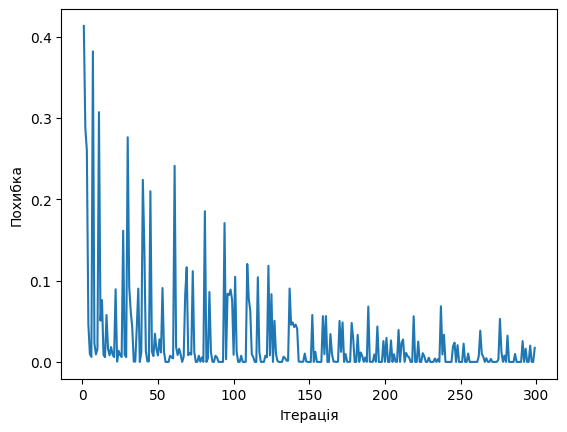

In [154]:
x = list(map(lambda pd: pd[0], plot_data))
y = list(map(lambda pd: pd[1], plot_data))

plt.plot(x, y)

plt.xlabel('Ітерація')
plt.ylabel('Похибка')

plt.show()